In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-market-data/market.csv


# Load libraries

In [11]:
import numpy as np

import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib as mpl

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [12]:
from mlxtend.frequent_patterns import apriori, association_rules

In [13]:
df_raw = pd.read_csv("/kaggle/input/real-market-data/market.csv",sep=";")
df_raw.head()

,Bread,Honey,Bacon,Toothpaste,Banana,Apple,Hazelnut,Cheese,Meat,Carrot,...,Milk,Butter,ShavingFoam,Salt,Flour,HeavyCream,Egg,Olive,Shampoo,Sugar
0,1,0,1,0,1,1,1,0,0,1,...,0,0,0,0,0,1,1,0,0,1
1,1,1,1,0,1,1,1,0,0,0,...,1,1,0,0,1,0,0,1,1,0
2,0,1,1,1,1,1,1,1,1,0,...,1,0,1,1,1,1,1,0,0,1
3,1,1,0,1,0,1,0,0,0,0,...,1,0,0,0,1,0,1,1,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df = df_raw.astype(bool)
df.head()

,Bread,Honey,Bacon,Toothpaste,Banana,Apple,Hazelnut,Cheese,Meat,Carrot,...,Milk,Butter,ShavingFoam,Salt,Flour,HeavyCream,Egg,Olive,Shampoo,Sugar
0,True,False,True,False,True,True,True,False,False,True,...,False,False,False,False,False,True,True,False,False,True
1,True,True,True,False,True,True,True,False,False,False,...,True,True,False,False,True,False,False,True,True,False
2,False,True,True,True,True,True,True,True,True,False,...,True,False,True,True,True,True,True,False,False,True
3,True,True,False,True,False,True,False,False,False,False,...,True,False,False,False,True,False,True,True,True,False
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Metric in Association Rule Mining

### What Does "Support" Really Mean?
When we're trying to find patterns in user behavior — like what people buy or watch together — support is the first signal we look for. Think of it as a popularity score: it tells us how often a certain combination of items shows up across all transactions (or in the case of Netflix, maybe across millions of viewing sessions).

📊 For example, if 100 people made purchases and 25 of them bought both eggs and milk, then the support for that itemset is 25%.

In simple terms:
Support of itemset = (Number of times an itemset appears) ÷ (Total number of transactions)

Why does this matter?
High support means the itemset is common — and worth paying attention to.
Low support patterns are often too rare to matter in large-scale recommendations.
For product teams or marketers, support helps surface the popular combos that drive user engagement or purchases.

In a streaming context? That’s like noticing Stranger Things and Dark are often binged together — and using that signal to improve recommendations or playlist curation.

### What Is "Confidence" in Association Rule Mining?
Let’s say we’ve already found that certain items tend to show up together — but how reliable is that pattern? That’s where the confidence metric comes in.

Confidence tells us:

“If item A appears, how likely is item B to appear as well?”

It’s essentially a probability score. For example, if 100 people buy bread, and 70 of them also buy butter, the confidence of the rule Bread → Butter is 70%.

Formula:
Confidence(A → B) = Support(A and B) ÷ Support(A)

📈 Why Confidence Matters
It’s predictive: The higher the confidence, the more trustworthy the rule. In retail or streaming, it means the behavior isn’t just a coincidence.

It ranks rules: Not all item pairs are equal — confidence helps us separate the strong signals from the noise.

It fuels recommendations: In a Netflix-like setting, if you watched Stranger Things, and there’s high confidence you’ll also enjoy Dark, the system can confidently recommend it.

### What Does “Lift” Tell Us?
While confidence tells us how likely two items appear together, lift goes a step further — it tells us whether that co-occurrence is actually interesting, or just a coincidence.

Think of lift as a way to measure the "surprise factor" in a pattern.

Lift = (Support of A and B together) ÷ (Support of A × Support of B)

If items A and B were totally unrelated, we’d expect them to occur together purely by chance. But if the lift is greater than 1, it means they show up together more often than random chance would suggest — a strong signal for a recommendation.

🔎 Why Lift Matters

* ✅ Lift > 1 → Positive association: “People who buy A really are more likely to buy B.”
* ⚖️ Lift ≈ 1 → No real relationship: The items appear together as often as chance allows.
* 🚫 Lift < 1 → Negative association: Buying A actually lowers the chance of B being bought.

#  Run the Apriori Algorithm

In [15]:
# Minimum support of 0.2 = itemsets present in at least 20% of transactions

min_support = 0.02
frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False).head()

,support,itemsets
4,0.448276,(Banana)
7,0.443966,(Cheese)
2,0.431034,(Bacon)
6,0.420259,(Hazelnut)
1,0.415948,(Honey)


# Generate Association Rules

In [16]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Make the antecedents and consequents readable
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10)


,antecedents,consequents,support,confidence,lift
782151,"Cheese, Meat, Egg","Apple, Carrot, Bacon, Honey, Hazelnut",0.021552,0.208333,8.055556
782058,"Apple, Carrot, Bacon, Honey, Hazelnut","Cheese, Meat, Egg",0.021552,0.833333,8.055556
782085,"Meat, Cheese, Carrot, Egg","Bacon, Honey, Apple, Hazelnut",0.021552,0.344828,7.619048
782124,"Bacon, Honey, Apple, Hazelnut","Meat, Cheese, Carrot, Egg",0.021552,0.476190,7.619048
782113,"Bacon, Hazelnut, Apple, Carrot","Cheese, Meat, Egg, Honey",0.021552,0.476190,7.619048
782096,"Cheese, Meat, Egg, Honey","Bacon, Hazelnut, Apple, Carrot",0.021552,0.344828,7.619048
782114,"Hazelnut, Honey, Apple, Carrot","Bacon, Cheese, Meat, Egg",0.021552,0.526316,7.400319
782095,"Bacon, Cheese, Meat, Egg","Hazelnut, Honey, Apple, Carrot",0.021552,0.303030,7.400319
782091,"Cheese, Carrot, Meat, Hazelnut","Bacon, Egg, Apple, Honey",0.021552,0.400000,7.138462
782118,"Bacon, Egg, Apple, Honey","Cheese, Carrot, Meat, Hazelnut",0.021552,0.384615,7.138462


# Visualize

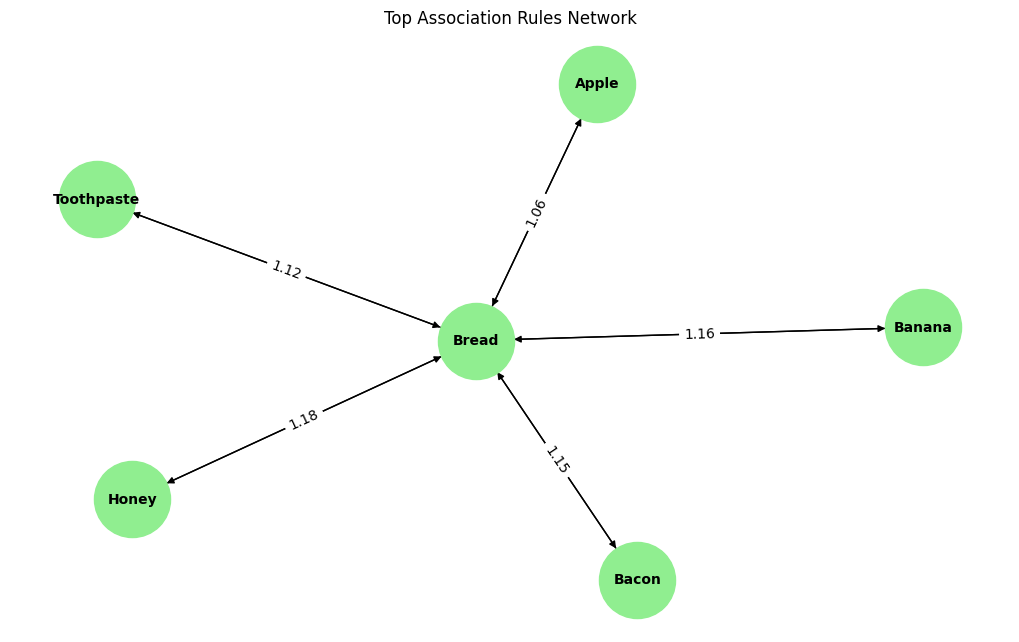

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

top_rules = rules.head(10)
G = nx.DiGraph()

for _, row in top_rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['lift'])

plt.figure(figsize=(10,6))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=3000, font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()})
plt.title("Top Association Rules Network")
plt.show()

# Final Thoughts: What Did the Network Tell Us?
From the association rule mining analysis, Bread clearly emerged as a central item — consistently linked with several others like Honey, Bacon, Toothpaste, Banana, and Apple.

Each arrow in the network diagram shows a rule such as:

Bread → Honey (Lift: 1.18)
Meaning: Customers who bought bread were 18% more likely to also buy honey — beyond what you'd expect by chance.

While some associations (like Bread → Apple with Lift 1.06) are relatively weak, others like Bread → Banana (Lift 1.16) suggest a stronger-than-random relationship.

### 🛒 Business Takeaways
Product bundling: Bread and banana could be placed near each other or promoted together.

Cross-sell opportunities: Even items like Toothpaste paired with bread (Lift 1.12) can hint at broader shopping behaviors — think of shared time-of-day purchases (morning routines).

Data-driven merchandising: These micro-patterns can be turned into real-world decisions — shelf placements, combo offers, or "frequently bought together" nudges.

This analysis showcases how even a small retail dataset can surface meaningful insights — and how Lift + Confidence + Support together help us distinguish between coincidence and true customer patterns.